In [ ]:
%load_ext autoreload
%autoreload 2

import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 14})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [ ]:
file = rf"./data/20251030_ff_2237_circular_rods_n_3p3_2.h5"
data_loaded = read_hdf5_as_dict(file)
data_loaded.keys()

In [ ]:
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 25))
plt.figure(figsize=(12, 7))
for j,n in enumerate(data_loaded["n_values"]):
    for i,ff in enumerate(data_loaded["ff"]):
        for k,size in enumerate(data_loaded["sizes"]):
            plt.plot((td.C_0/data_loaded["raw_freqs"])/0.8,data_loaded["transmission_data"][str(n)][str(size)][str(ff)]["exit"],label=rf"size={size:.2f}",color=colors[k])

plt.legend(loc=2)
plt.yscale("log")
plt.xlabel(rf"$\lambda[\mu m]$")
plt.ylabel("Transmission")
plt.grid(True,which="both")
plt.title("Transmission solid rods n=3.3")


plt.tight_layout()

plt.show()

In [ ]:
folder_convergence = "./plots/convergence/n_3.3"
os.makedirs(folder_convergence,exist_ok=True)
plt.figure(figsize=(14, 10))
for j,n in enumerate(data_loaded["n_values"]):
    for i,ff in enumerate(data_loaded["ff"]):
        for k,size in enumerate(data_loaded["sizes"]):
            plt.plot(td.C_0/data_loaded["raw_freqs"],data_loaded["transmission_data"][str(n)][str(size)][str(ff)]["entry"],label=rf"Entry")
            plt.plot(td.C_0/data_loaded["raw_freqs"],data_loaded["transmission_data"][str(n)][str(size)][str(ff)]["exit"],label=rf"Exit")
            plt.legend(loc=2)
            plt.yscale("log")
            plt.xlabel(rf"$\lambda[\mu m]$")
            plt.ylabel("Transmission")
            plt.grid(True,which="both")
            plt.title(rf"$L={size*14.3}$")
            plt.tight_layout()
            plt.savefig(rf"{folder_convergence}/L_{size*14.3 : .4f}.png")
            plt.close()

In [ ]:
#Create array for easier analysis 
transmission_array = np.stack([[[data_loaded["transmission_data"][str(n)][str(size)][str(ff)]["exit"] for size in data_loaded["sizes"]] for ff in data_loaded["ff"]] for n in data_loaded["n_values"]]).squeeze()
transmission_array=transmission_array[:-3,:]

In [ ]:
folder = "./plots/transmission_L_loglog/n_3.3"
os.makedirs("./plots/transmission_L_loglog/n_3.3",exist_ok=True)

In [ ]:
lambdas = td.C_0/data_loaded["raw_freqs"]/0.8
sizes = (np.array(data_loaded["sizes"],dtype=np.float32)*14.3)[:-3]

In [ ]:
for i,item in enumerate(transmission_array.T): 
    plt.figure(figsize=(14, 10))
    plt.scatter(sizes,item)
    plt.title(rf"$\lambda = {lambdas[i]:.4f}$")
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("Transmission")
    plt.xlabel(r"$L [\mu m]$")
    plt.savefig(rf"{folder}/lambda_{lambdas[i]:.4f}.png")
    plt.close()

In [ ]:
#get ls values 
ls_values = AM.read_hdf5_as_dict("../data/ls_values/20251031_ls_values_n_3p3.h5")
ls_retrieved = ls_values["0.2237"]

In [ ]:
#get derivatives 
dlogT_dlogL = []
for i,item in enumerate(transmission_array.T): 
    y = np.log(item)  # log T
    x = np.log(sizes)
    p, cov = np.polyfit(x, y, deg=1, cov=True)
    slope = p[0]
    dlogT_dlogL.append(slope)


In [ ]:
k = 2*np.pi/lambdas
n_eff= np.sqrt((1-float("0.2237"))+float("0.2237")*(3.3**2))
plt.scatter(k*n_eff*ls_retrieved,dlogT_dlogL)
plt.ylabel(rf"$dLog(T)/dLog(L)$")
plt.xlabel(rf"$k \cdot l_s$")
plt.grid(visible=True,which="both")

In [115]:
g_values = AM.read_hdf5_as_dict("../data/ls_values/20251103_g_values_ff_22p37_n_3p3.h5")["g_values"]
freqs_g =  AM.read_hdf5_as_dict("../data/ls_values/20251103_g_values_ff_22p37_n_3p3.h5")["freqs"]

In [116]:
lambdas_g = td.C_0/freqs_g

In [117]:
import numpy as np

def nearest_indices(source, target):
    """
    For each value in `source`, return the index in `target` of the closest value.
    """
    target = np.asarray(target)
    source = np.asarray(source)

    # sort target but remember original indices
    order = np.argsort(target)
    t_sorted = target[order]

    # where each source value would be inserted
    pos = np.searchsorted(t_sorted, source)

    # candidate neighbors (left/right) within bounds
    left = np.clip(pos - 1, 0, len(t_sorted) - 1)
    right = np.clip(pos,     0, len(t_sorted) - 1)

    # pick closer neighbor
    pick_left = np.abs(source - t_sorted[left]) <= np.abs(t_sorted[right] - source)
    nearest_sorted_idx = np.where(pick_left, left, right)

    # map back to original target indices
    return order[nearest_sorted_idx]


In [118]:
#get indices matching g with ls 
indices_wvl = nearest_indices(lambdas_g,lambdas)

In [119]:
l_star = np.array(ls_retrieved)[indices_wvl]/(1-np.array(g_values))

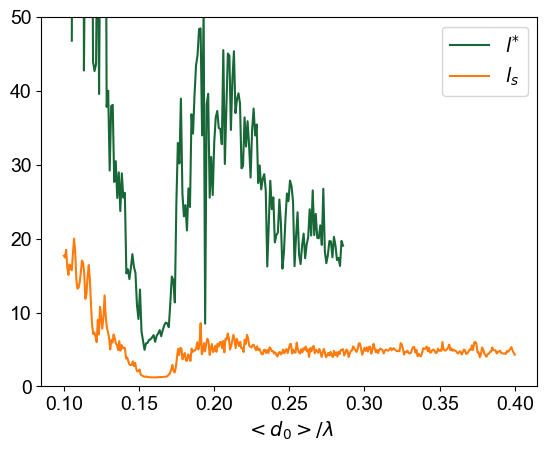

In [120]:
plt.plot(1/lambdas_g,l_star,label=rf"$l^{{*}}$")
plt.plot(1/lambdas,ls_retrieved,label=r"$l_s$")
plt.legend()
plt.xlabel(r"$<d_0>/\lambda$")
plt.ylim(0,50)
plt.show()